In [2]:
# ENCODE id
encode_id = 'ENCSR000AHD'

# Set variables
expansion_factor = 4.0
topk_fraction = 0.05
center_length = 1000
epochs = 3
inner_bs = 16384
lr = 1e-3

# Output Directory
out_base_dir = f'/scratch/users/jgalante/SparseNet/ENCSR000AHD/'
sample_name = f'expansion_{expansion_factor}_topk_{topk_fraction}_center_len_{center_length}'
out_dir = out_base_dir + sample_name

# # pwm settings
pwm_layer = 0 
receptive_field = 21 if pwm_layer == 0 else 2**(pwm_layer + 1)
num_samples_per_node = 1000
num_top_nodes = 10

Loading Loci: 100%|██████████| 225888/225888 [00:38<00:00, 5841.80it/s]



Filtered Peaks: 312
Filtered Negatives: 0


Loading Loci: 100%|██████████| 56472/56472 [00:36<00:00, 1544.95it/s]



[1/9] Training layer: irelu
[irelu] Computing channel max for normalization...
[irelu] Training for 3 epochs...
[irelu] Epoch 1 finished.
[irelu] Epoch 2 finished.
[irelu] Epoch 3 finished.
  ✓ Saved: /scratch/users/jgalante/SparseNet/ENCSR000AHD/expansion_4.0_topk_0.05_center_len_1000/models/irelu.pt

[2/9] Training layer: rrelus.0
[rrelus.0] Computing channel max for normalization...
[rrelus.0] Training for 3 epochs...
[rrelus.0] Epoch 1 finished.
[rrelus.0] Epoch 2 finished.
[rrelus.0] Epoch 3 finished.
  ✓ Saved: /scratch/users/jgalante/SparseNet/ENCSR000AHD/expansion_4.0_topk_0.05_center_len_1000/models/rrelus_0.pt

[3/9] Training layer: rrelus.1
[rrelus.1] Computing channel max for normalization...
[rrelus.1] Training for 3 epochs...
[rrelus.1] Epoch 1 finished.
[rrelus.1] Epoch 2 finished.
[rrelus.1] Epoch 3 finished.
  ✓ Saved: /scratch/users/jgalante/SparseNet/ENCSR000AHD/expansion_4.0_topk_0.05_center_len_1000/models/rrelus_1.pt

[4/9] Training layer: rrelus.2
[rrelus.2] Com

Saved metadata


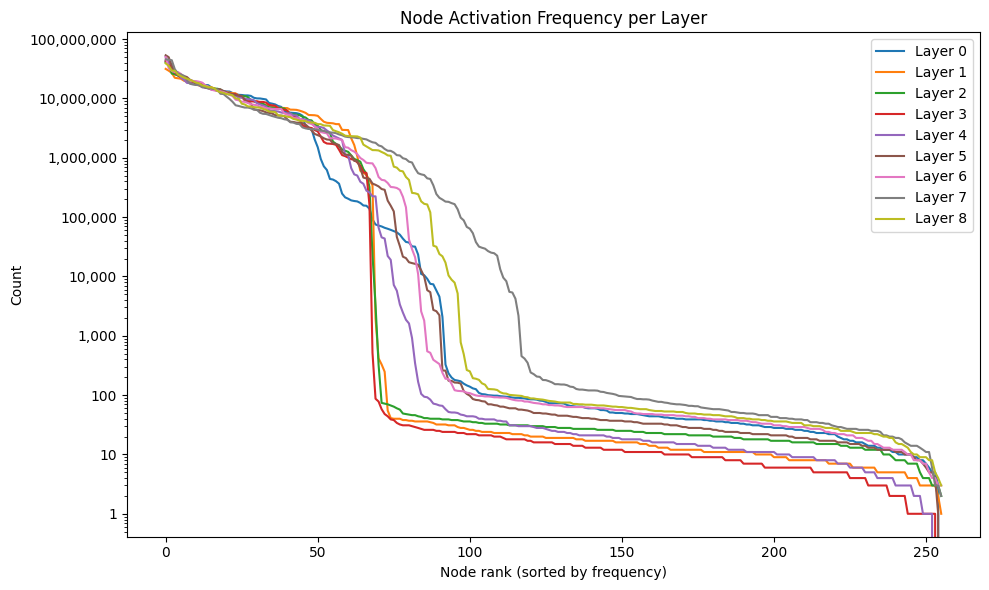

Plotting logos: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


In [2]:
# Prepare training data and other information
import numpy
import os
import torch
from bpnetlite.io import PeakGenerator
from scripts import deterministic_data_loaders as ddl
from scripts import models as mds
from scripts import SAE_trainer as st
from scripts import save_activations as sa
from scripts import create_PWM_for_nodes as pwm
from scripts import plot_activation_frequencies as nf

# Data source path
data_dir = '/scratch/users/jgalante/data'

# Paths
peaks_bed = f"{data_dir}/{encode_id}/peaks_inliers.bed.gz"
seqs = f'{data_dir}/reference/hg38.fa'
signal_plus = f"{data_dir}/{encode_id}/{encode_id}_plus.bigWig"
signal_minus = f"{data_dir}/{encode_id}/{encode_id}_minus.bigWig"
ctl_plus = f"{data_dir}/{encode_id}/{encode_id}_control_plus.bigWig"
ctl_minus = f"{data_dir}/{encode_id}/{encode_id}_control_minus.bigWig"
negatives_bed = f"{data_dir}/{encode_id}/gc_neg_only_sorted.bed.gz"

# Model
model_path = f'{data_dir}/{encode_id}/model.h5'

training_data = PeakGenerator(
    peaks = peaks_bed,
    negatives = negatives_bed,
    sequences = seqs,
    signals = [signal_plus, signal_minus],
    controls = [ctl_plus, ctl_minus],
    chroms = None,
    in_window = 2114,
    out_window = 1000,
    max_jitter = 128,
    negative_ratio = 0.33,
    reverse_complement = True,
    shuffle = True,
    min_counts = None,
    max_counts = None,
    summits = False,
    exclusion_lists = None,
    random_state = 12345,
    pin_memory = True,
    num_workers = 0,
    batch_size = 64,
    verbose = True
)

# Initialize the dataloader to pass all peaks through SAEs and capture activations in order of bed file
sae_testing_data = ddl.DeterministicPeakGenerator(
    peaks=peaks_bed,
    sequences=seqs,
    signals=[signal_plus, signal_minus],
    chroms=None,
    in_window=2114,
    out_window=1000,
    pin_memory=True,
    batch_size=64,
    verbose=True
)

# Instantiate the trainer object
trainer = st.SAETrainer(model_path=model_path, device="cuda", center_len=center_length)

# Train an SAE for each layer on all training data with given hyperparameters
trainer.train_all(
    train_loader=training_data,
    sae_cls=mds.SAETopK,
    sae_kwargs={"latent_multiplier": expansion_factor, "k_fraction": topk_fraction},
    save_dir=f'{out_dir}/models',
    logs_dir=f'{out_dir}/models/logs',
    epochs=epochs,
    inner_bs=inner_bs,
    lr=lr,
    log_every=50,
)

# Load the trained SAEs from disk written by trainer.train_all()
sae_models = mds.load_saes_from_dir(save_dir=f'{out_dir}/models', layers=trainer.layers, device=trainer.device)

# Run Top-K collection over deterministic data loader
meta = sa.collect_topk_indices_to_disk_from_trainer(
    trainer=trainer,
    sae_models=sae_models,
    loader=sae_testing_data,
    out_dir=f'{out_dir}/activations',
)

# Plot node activation frequencies
nf.plot_node_activation_frequencies(
	num_layers = len(trainer.layers), 
	latent_dim = int(64*expansion_factor), 
	data_dir = f'{out_dir}/activations'
)

# Get PWMs for the top N nodes in a given layer over S top activating samples per node
pwm_results = pwm.create_PWM_for_top_N_nodes(
    layer=pwm_layer,
    receptive_field=receptive_field,
    num_top_nodes=num_top_nodes,
    data_dir=f'{out_dir}/activations',
	out_dir = f'{out_dir}/pwms',
    loader=sae_testing_data,
	latent_dim = int(expansion_factor*64), # 64 channels * expansion factor
    num_samples_per_node=num_samples_per_node
)

# Create pwm plots and save
pwm.plot_node_pwms_from_meta(data_dir=f'{out_dir}/pwms')

In [3]:
sample_name

'expansion_4.0_topk_0.05_center_len_1000'